## Random Forest para classificação de avaliações de livros

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

In [3]:
warnings.filterwarnings("ignore")

### Carregando o dataset

In [4]:
df_train = pd.read_csv('../data/treated_data/train.csv', sep=';')
df_val = pd.read_csv('../data/treated_data/val.csv', sep=';')
df_test = pd.read_csv('../data/treated_data/test.csv', sep=';')

Vamos juntar os datasets de treino e validação, visto que random forest não utiliza dados para validação separadamente dos dados de treino.

In [5]:
df_train = pd.concat([df_train, df_val], axis=0, ignore_index=True)
df_train = df_train.sample(frac=1, replace=False).reset_index(drop=True)

In [6]:
df_train.columns

Index(['language_code', 'is_ebook', 'num_pages', 'author_rating',
       'author_reviews_count', 'author_ratings_count', 'book_format_Hardcover',
       'book_format_Kindle-Edition', 'book_format_Mass-Market-Paperback',
       'book_format_Paperback', 'book_format_ebook', 'book_format_other',
       'book_genre_fantasy', 'book_genre_fiction', 'book_genre_history',
       'book_genre_mystery', 'book_genre_non-fiction', 'book_genre_other',
       'book_genre_romance', 'rating'],
      dtype='object')

### Criação do modelo base

In [7]:
X_train = df_train.drop(['rating'], axis=1)
y_train = df_train['rating'].values

X_test = df_test.drop(['rating'], axis=1)
y_test = df_test['rating'].values

In [7]:
model = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    criterion='gini',
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=df_train.shape[1]
)

In [8]:
model.fit(X=X_train, y=y_train)

RandomForestClassifier(max_depth=10, max_features=20, n_estimators=10)

In [ ]:
y_pred = model.predict(X_test)
y_pred_scores = model.predict_proba(X_test)

In [10]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.2f}')

Acurácia: 0.72


### Grid Search para encontrar os melhores hiperparâmetros

In [11]:
param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [df_train.shape[1]]
}

In [12]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

In [13]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=10, max_features=20,
                                              n_estimators=10),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'max_features': [20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [10, 25, 50]},
             scoring='accuracy', verbose=2)

In [14]:
print(f"Melhores hiperparâmetros: {grid_search.best_params_}")
print(f"Melhor acurácia obtida: {grid_search.best_score_:.2f}")

Melhores hiperparâmetros: {'max_depth': 20, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Melhor acurácia obtida: 0.82


In [15]:
best_model = grid_search.best_estimator_

### Salvando o melhor modelo

In [ ]:
with open('../models/random_forest_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

### Avaliando o modelo

Primeiro vamos carregar o modelo salvo, para não ser necessário rodar todo o notebook novamente.

In [ ]:
# Carregando o modelo salvo
with open('../models/random_forest_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [9]:
y_pred = model.predict(X_test)
y_pred_scores = model.predict_proba(X_test)

In [16]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')

print(f'Acurácia: {accuracy:.2f}')
print(f'Precisão: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1_score:.2f}')

Acurácia: 0.74
Precisão: 0.69
Recall: 0.68
F1-Score: 0.69


In [17]:
cm = confusion_matrix(y_test, y_pred)

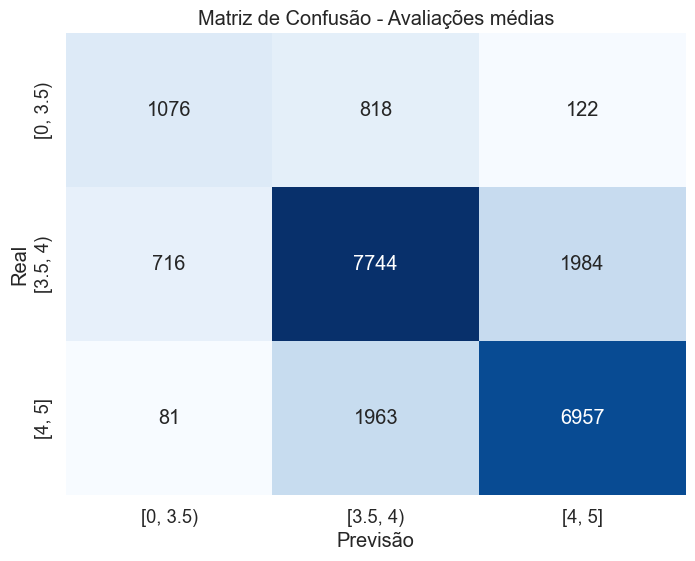

In [24]:
# Criando a matriz de confusão

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['[0, 3.5)', '[3.5, 4)', '[4, 5]'], yticklabels=['[0, 3.5)', '[3.5, 4)', '[4, 5]'])


plt.title('Matriz de Confusão - Avaliações médias')
plt.xlabel('Previsão')
plt.ylabel('Real')

plt.show()

Analisando os resultados obtidos, é possível perceber que o modelo de classificação tem um resultado razoável, com acurácia de 0.74 e F1-Score de 0.69, indicando um bom equilíbrio entre precisão e recall. No entanto, a análise da matriz de confusão revela erros significativos entre classes adjacentes, o que sugera possíveis melhorias, principalmente referentes aos limiares de decisão.